In [ ]:
!python --version

Python 3.12.11


In [ ]:
!pip install torch torchvision

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results


Random Seed:  999


In [ ]:
!pip install matplotlib

     ---------------------------------------- 0.0/111.1 kB ? eta -:--:--
     ----------- ---------------------------- 30.7/111.1 kB ? eta -:--:--
     ----------------------------------- -- 102.4/111.1 kB 3.0 MB/s eta 0:00:01
     -------------------------------------- 111.1/111.1 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
    --------------------------------------- 0.1/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.4/8.1 MB 5.5 MB/s eta 0:00:02
   --- ------------------------------------ 0.7/8.1 MB 5.2 MB/s eta 0:00:02
   ---- ----------------------------------- 0.8/8.1 MB 5.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/8.1 MB 5.2 MB/s eta 0:00:02
   ------ --------------------------------- 1.4/8.1 MB 5.4 MB/s eta 0:00:02
   ------- -------------------------------- 1.6/8.1 MB 5.4 MB/s eta 0:00:02
   --------- ------------------------------ 1.9/8.1 MB 5.6 MB/s eta 0:00:02
   ---------- ---------


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#Hyperparameters etc.
#dataset directory
datasetdir = "./resource"

#Number of workers for dataloader
workers = 2

#Batch size during training
batch_size = 128

#Spatial size of training images. All images will be resized to this
#size using a transformer
img_size = 64

#Input channels
nc = 1

#z vector size
z_dim = 100

#Size of feature maps in discriminator (output channels)
ndf = 64

#Number of training epochs
num_epochs = 40

#Learning rate of optimizers
lr = 0.0002

#Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

#Number of GPUs available
ngpu = 1

In [ ]:
#data input and device selection

#create dataset
#MNIST dataset for mock testing
dataset = MNIST(root=datasetdir,
                     train=True,
                     download=True,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.14MB/s]


In [ ]:
#custom weights initialization called on ``netG`` and ``netD``
def weights_init(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
#Discriminator Code
class Discriminator(nn.Module):
    def __init__(self, channels, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            #Input: N * channels x 64 x 64
            nn.Conv2d(
                channels, features_d, kernel_size=4, stride=2, padding=1
            ), #34 x 34 pixel values
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # 16x16
            self._block(features_d*2, features_d*4, 4, 2, 1), # 8x8
            self._block(features_d*4, features_d*8, 4, 2, 1), # 4x4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0, bias=False), # 1x1 (also converts to a single channel)
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            #input is ``(nx) * 64 * 64``
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels), #not in the official docs
            nn.LeakyReLU(0.2)
        )

    def forward(self, input):
        return self.disc(input)

In [ ]:
#Generator Code

class Generator(nn.Module):
    def __init__(self, z_dim, channels, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            #input : N x z_dim x 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0), # N x f_g*16 x 4 x 4
            self._block(features_g*16, features_g*8, 4, 2, 1), # 8 x 8
            self._block(features_g*8, features_g*4, 4, 2, 1), # 16 x 16
            self._block(features_g*4, features_g*2, 4, 2, 1), # 32 x 32
            nn.ConvTranspose2d(
                features_g*2, channels, kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.Tanh() # normalizes range within [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, input):
        return self.gen(input)

In [ ]:
#initialise generator and discriminator

gen = Generator(z_dim, nc, 8).to(device)
disc = Discriminator(nc, 8).to(device)
weights_init(gen)
weights_init(disc)

In [ ]:
#Loss calculator
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

#establish real and fake labels
real_label = 1.
fake_label = 0.

#setup Adam optimiers for both G and D
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()

In [ ]:
#Training loop

G_losses = []
D_losses = []
i = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        disc.zero_grad()
        #Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = gen(noise)

        #Train Discriminator maximize log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        optimizerD.step()

        #Train Generator maximize log(D(G(z))) or minimize log(1 - D(G(z)))
        output = disc(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimizerG.step()

        #Print losses
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     loss_disc, loss_gen))

            with torch.no_grad():
                fake = gen(fixed_noise)
                #take out (up to) 32 examples
                img_grid_real = vutils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = vutils.make_grid(
                    fake[:32], normalize=True
                )

                #Losses for plotting
                G_losses.append(loss_gen)
                D_losses.append(loss_disc)




/tmp/ipython-input-2277289425.py:37: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'


[0/40][0/469]	Loss_D: 0.6940	Loss_G: 0.6947
[0/40][100/469]	Loss_D: 0.2424	Loss_G: 1.5018
[0/40][200/469]	Loss_D: 0.0655	Loss_G: 2.6867
[0/40][300/469]	Loss_D: 0.0265	Loss_G: 3.5669
[0/40][400/469]	Loss_D: 0.0138	Loss_G: 4.1997
[1/40][0/469]	Loss_D: 0.0098	Loss_G: 4.5352
[1/40][100/469]	Loss_D: 0.0179	Loss_G: 3.8499
[1/40][200/469]	Loss_D: 0.7251	Loss_G: 0.7093
[1/40][300/469]	Loss_D: 0.7007	Loss_G: 0.7040
[1/40][400/469]	Loss_D: 0.6675	Loss_G: 0.7453
[2/40][0/469]	Loss_D: 0.6119	Loss_G: 0.5466
[2/40][100/469]	Loss_D: 0.6258	Loss_G: 1.0328
[2/40][200/469]	Loss_D: 0.6259	Loss_G: 0.6275
[2/40][300/469]	Loss_D: 0.6653	Loss_G: 0.8232
[2/40][400/469]	Loss_D: 0.6454	Loss_G: 0.8823
[3/40][0/469]	Loss_D: 0.6277	Loss_G: 0.8133
[3/40][100/469]	Loss_D: 0.6521	Loss_G: 0.7928
[3/40][200/469]	Loss_D: 0.6257	Loss_G: 0.7186
[3/40][300/469]	Loss_D: 0.6952	Loss_G: 0.5104
[3/40][400/469]	Loss_D: 0.6542	Loss_G: 0.6807
[4/40][0/469]	Loss_D: 0.6635	Loss_G: 0.8092
[4/40][100/469]	Loss_D: 0.6600	Loss_G: 0.655

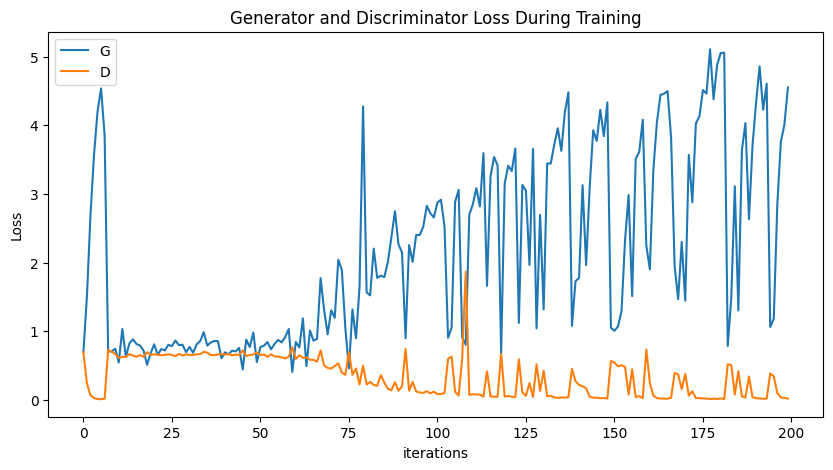

In [ ]:
#plotting for losses
G_losses = [loss.item() if torch.is_tensor(loss) else loss for loss in G_losses]
D_losses = [loss.item() if torch.is_tensor(loss) else loss for loss in D_losses]

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

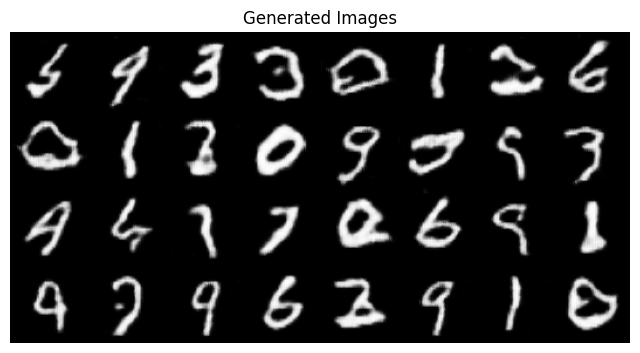

In [ ]:
#plotting for images
plt.figure(figsize=(8, 8))
plt.title("Generated Images")
plt.axis("off")
plt.imshow(np.transpose(img_grid_fake, (1, 2, 0)))
plt.show()

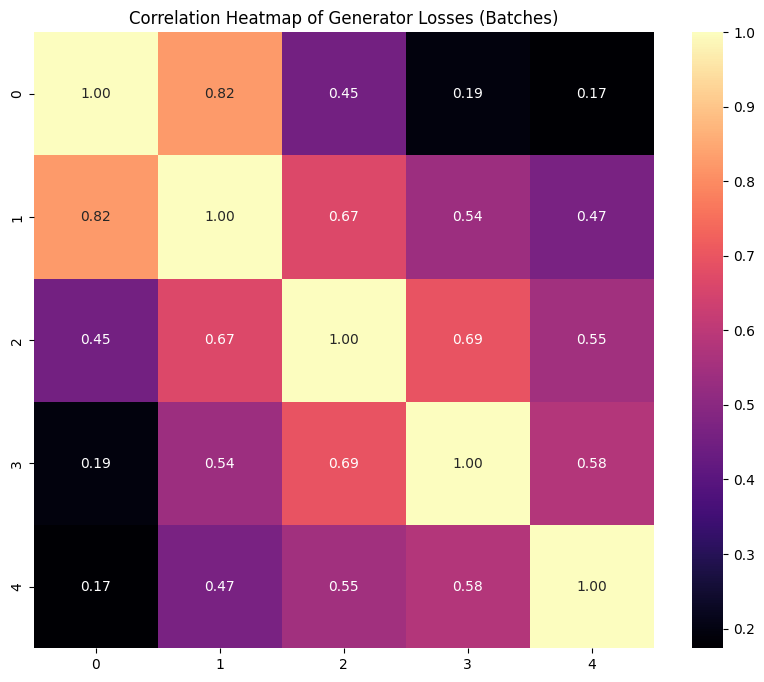

In [ ]:
import pandas as pd
import seaborn as sns
#plotting heatmap G_losses
batches_per_epoch = len(G_losses) // 40

G_matrix = np.array(G_losses).reshape(num_epochs, batches_per_epoch)
D_matrix = np.array(D_losses).reshape(num_epochs, batches_per_epoch)

# Put into DataFrame (columns = batches, rows = epochs)
df_G = pd.DataFrame(G_matrix)

# Compute correlation
corr = df_G.corr()

# Plot annotated heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="magma", cbar=True)
plt.title("Correlation Heatmap of Generator Losses (Batches)")
plt.show()


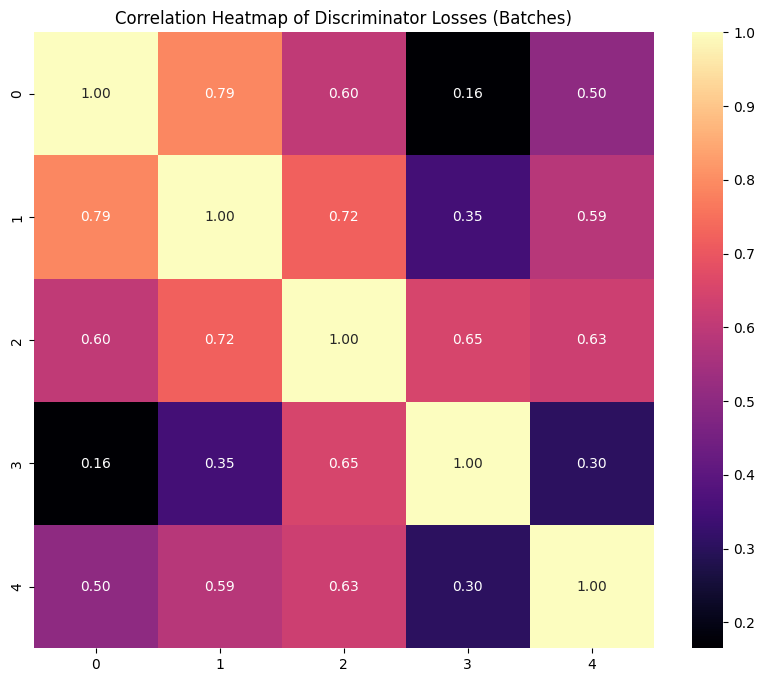

In [ ]:
#plotting heatmap D_losses
# Put into DataFrame (columns = batches, rows = epochs)
df_D = pd.DataFrame(D_matrix)

# Compute correlation
corr = df_D.corr()

# Plot annotated heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="magma", cbar=True)
plt.title("Correlation Heatmap of Discriminator Losses (Batches)")
plt.show()


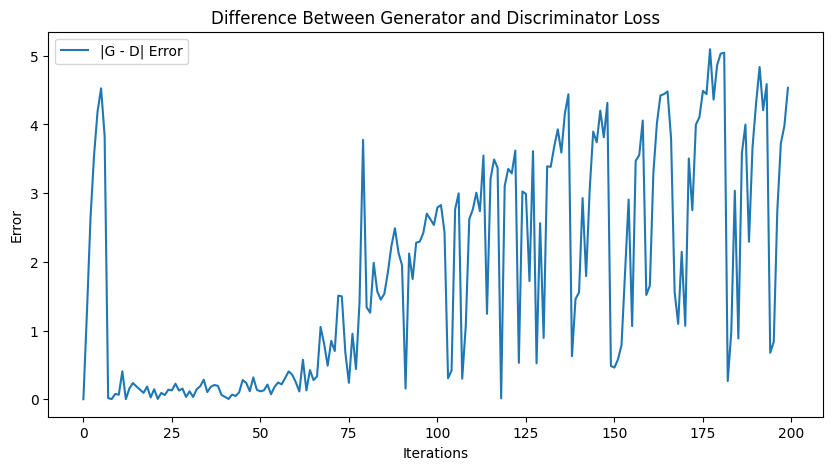

In [ ]:
#error calculation

errors = np.abs(np.array(G_losses) - np.array(D_losses))

plt.figure(figsize=(10,5))
plt.plot(errors, label="|G - D| Error")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("Difference Between Generator and Discriminator Loss")
plt.legend()
plt.show()

In [ ]:
#lstm hyper parameters
seq_len = 10
input_dim = 100
hidden_dim = 128
num_layers = 1

In [ ]:
#implementing conditional DCGAN with lstm as input instead of vector noise
#currently only takes last layer of hidden state as input
class Generator(nn.Module):
  def __init__(self, z_dim, channels ,features_g, hidden_size):
    super(Generator, self).__init__()
    #encode lstm parameters
    self.lstm = nn.LSTM(input_size=z_dim,
                        hidden_size=hidden_size,
                        num_layers=1,
                        bias=True,
                        batch_first=True)

    self.gen = nn.Sequential(
          #input : N x hidden_size x 1 x 1
          self._block(hidden_size, features_g*16, 4, 1, 0), # N x f_g*16 x 4 x 4
          self._block(features_g*16, features_g*8, 4, 2, 1), # 8 x 8
          self._block(features_g*8, features_g*4, 4, 2, 1), # 16 x 16
          self._block(features_g*4, features_g*2, 4, 2, 1), # 32 x 32
          nn.ConvTranspose2d(
              features_g*2, channels, kernel_size=4, stride=2, padding=1, bias=False
          ),
          nn.Tanh() # normalizes range within [-1, 1]
      )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
      return nn.Sequential(
          nn.ConvTranspose2d(
              in_channels,
              out_channels,
              kernel_size,
              stride,
              padding,
              bias=False
          ),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(True)
      )

  def forward(self, z_seq):
    _, (h_n, _) = self.lstm(z_seq) #extract the hidden state from output
    #h0 and c0 will be zero
    h_last = h_n[-1] #last layer of hidden state

    h_last = h_last.unsqueeze(-1).unsqueeze(-1) #modify dimensions

    return self.gen(h_last)


In [ ]:
gen = Generator(z_dim, nc, 8, hidden_dim).to(device)
disc = Discriminator(nc, 8).to(device)
weights_init(gen)
weights_init(disc)

In [ ]:
#Loss calculator
fixed_seq = torch.randn(64, seq_len, z_dim, device=device)

#Initialze lstm
lstm = nn.LSTM(input_size=input_dim,
               hidden_size=hidden_dim,
               num_layers=num_layers,
               batch_first=True).to(device)

#establish real and fake labels
real_label = 1.
fake_label = 0.

#setup Adam optimiers for both G and D
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()

In [ ]:
#Training loop for lstm hybrid model

G_losses = []
D_losses = []
i = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        disc.zero_grad()
        #Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        #noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        lstm_input = torch.randn((batch_size, seq_len, input_dim)).to(device)
        #lstm_output, _ = lstm(lstm_input)
        #z = lstm_output[:, -1, :].unsqueeze(-1).unsqueeze(-1)
        fake = gen(lstm_input)

        #Train Discriminator maximize log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        #train on fake images with LSTM output as vector input
        disc_fake = disc(fake).view(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        optimizerD.step()

        #Train Generator maximize log(D(G(z))) or minimize log(1 - D(G(z)))
        output = disc(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimizerG.step()

        #Print losses
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     loss_disc, loss_gen))

            with torch.no_grad():
                fake = gen(fixed_seq)
                #take out (up to) 32 examples
                img_grid_real = vutils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = vutils.make_grid(
                    fake[:32], normalize=True
                )

                #Losses for plotting
                G_losses.append(loss_gen)
                D_losses.append(loss_disc)




/tmp/ipython-input-2474596572.py:42: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'


[0/40][0/469]	Loss_D: 0.6952	Loss_G: 0.6929
[0/40][100/469]	Loss_D: 0.2328	Loss_G: 1.5395
[0/40][200/469]	Loss_D: 0.0638	Loss_G: 2.6884
[0/40][300/469]	Loss_D: 0.0257	Loss_G: 3.5547
[0/40][400/469]	Loss_D: 0.0152	Loss_G: 4.1200
[1/40][0/469]	Loss_D: 0.0121	Loss_G: 4.2734
[1/40][100/469]	Loss_D: 0.0098	Loss_G: 4.4013
[1/40][200/469]	Loss_D: 0.7456	Loss_G: 0.0597
[1/40][300/469]	Loss_D: 0.2447	Loss_G: 1.6821
[1/40][400/469]	Loss_D: 0.3990	Loss_G: 1.3177
[2/40][0/469]	Loss_D: 0.2573	Loss_G: 1.9885
[2/40][100/469]	Loss_D: 0.5431	Loss_G: 1.0527
[2/40][200/469]	Loss_D: 0.5733	Loss_G: 1.1170
[2/40][300/469]	Loss_D: 0.6144	Loss_G: 1.5159
[2/40][400/469]	Loss_D: 0.4202	Loss_G: 1.7449
[3/40][0/469]	Loss_D: 0.6540	Loss_G: 0.8714
[3/40][100/469]	Loss_D: 0.6267	Loss_G: 0.8910
[3/40][200/469]	Loss_D: 0.6797	Loss_G: 0.9173
[3/40][300/469]	Loss_D: 0.6761	Loss_G: 1.5845
[3/40][400/469]	Loss_D: 0.4586	Loss_G: 1.2380
[4/40][0/469]	Loss_D: 0.6639	Loss_G: 1.0468
[4/40][100/469]	Loss_D: 0.6146	Loss_G: 1.090

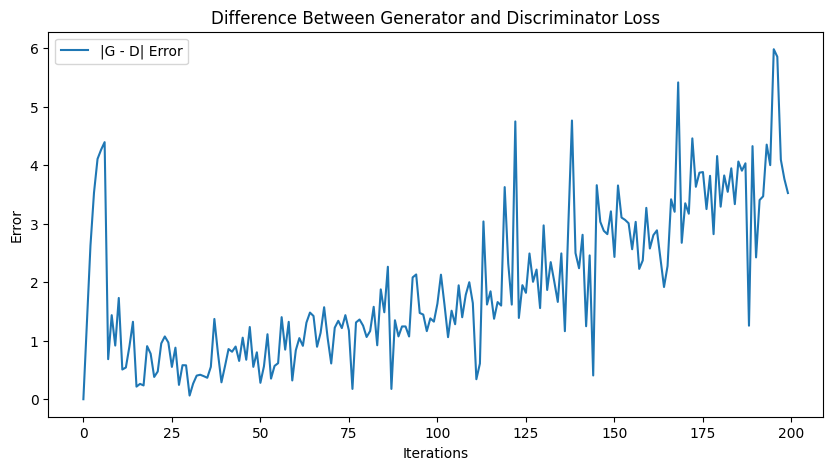

In [ ]:
#error calculation for lstm

G_losses = [g.detach().cpu().item() for g in G_losses]
D_losses = [d.detach().cpu().item() for d in D_losses]

errors = np.abs(np.array(G_losses) - np.array(D_losses))

plt.figure(figsize=(10,5))
plt.plot(errors, label="|G - D| Error")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("Difference Between Generator and Discriminator Loss")
plt.legend()
plt.show()

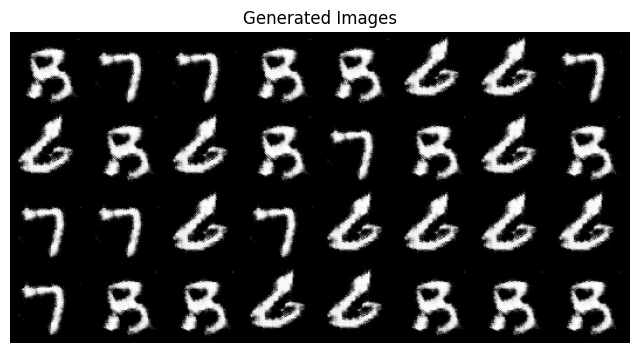

In [ ]:
#plotting for images
plt.figure(figsize=(8, 8))
plt.title("Generated Images")
plt.axis("off")
plt.imshow(np.transpose(img_grid_fake, (1, 2, 0)))
plt.show()

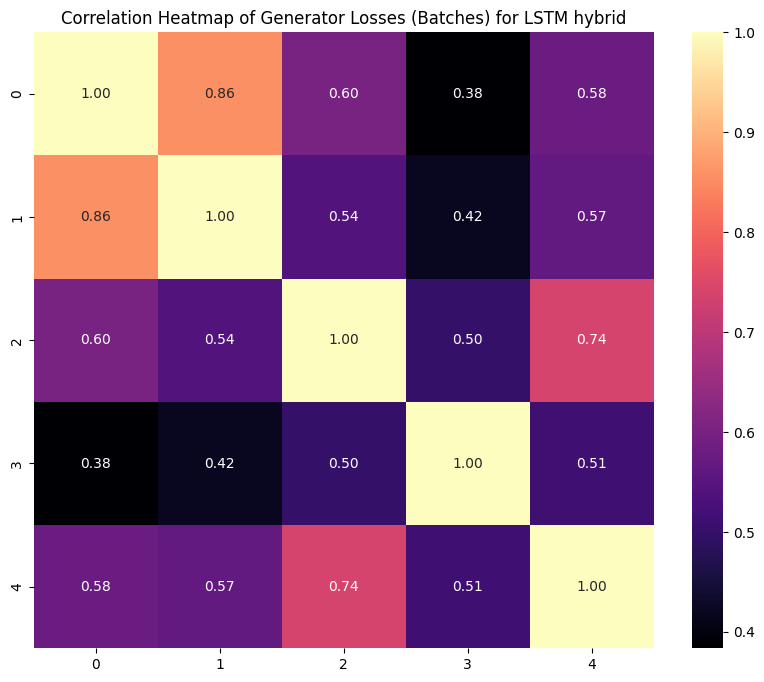

In [ ]:
import pandas as pd
import seaborn as sns
#plotting heatmap G_losses for LSTM hybrid
batches_per_epoch = len(G_losses) // 40

G_matrix = np.array(G_losses).reshape(num_epochs, batches_per_epoch)
D_matrix = np.array(D_losses).reshape(num_epochs, batches_per_epoch)

# Put into DataFrame (columns = batches, rows = epochs)
df_G = pd.DataFrame(G_matrix)

# Compute correlation
corr = df_G.corr()

# Plot annotated heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="magma", cbar=True)
plt.title("Correlation Heatmap of Generator Losses (Batches) for LSTM hybrid")
plt.show()


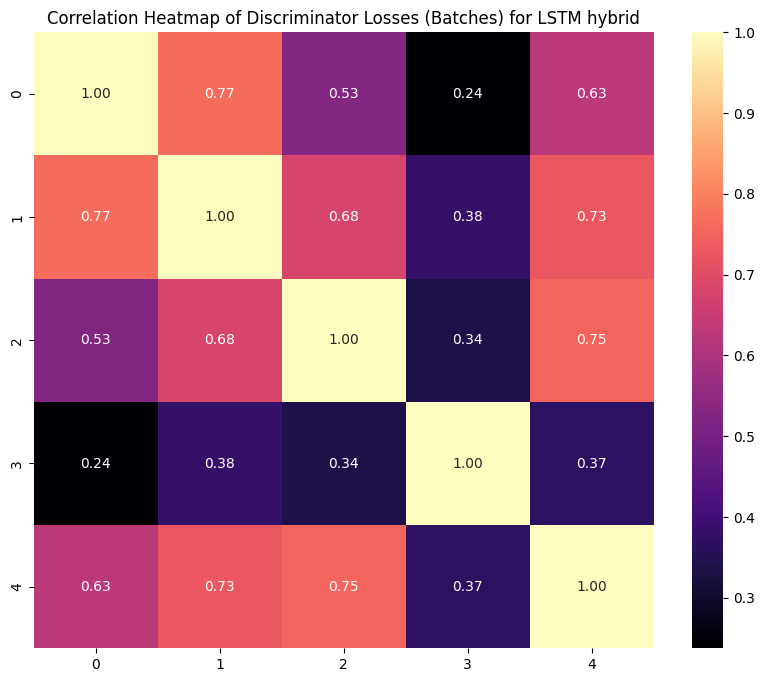

In [ ]:
#plotting heatmap D_losses for LSTM hybrid
# Put into DataFrame (columns = batches, rows = epochs)
df_D = pd.DataFrame(D_matrix)

# Compute correlation
corr = df_D.corr()

# Plot annotated heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="magma", cbar=True)
plt.title("Correlation Heatmap of Discriminator Losses (Batches) for LSTM hybrid")
plt.show()
